# Quantization in Deep Learning 

This notebook introduces quantization techniques in deep learning, with special attention to their application in Large Language Models (LLMs).

## 1. Introduction & Motivation

Quantization is a technique that reduces the precision of numerical representations in neural networks. Instead of using full 32-bit floating-point numbers to represent weights and activations, quantization uses lower-precision formats (e.g., 8-bit integers, 4-bit, or even 1-bit).

**Key benefits:**
- Reduced memory footprint (up to 75% smaller with 8-bit quantization)
- Faster inference (2-4x speedups common on compatible hardware)
- Lower energy consumption (critical for mobile/edge deployment)
- Enables deployment on resource-constrained devices

These benefits are particularly significant for Large Language Models with billions of parameters, where full-precision models may require hundreds of gigabytes of memory. Recent research shows many LLMs can be quantized to 4-bit precision with minimal performance degradation, making them accessible on consumer hardware.

## 2. What is Quantization?

Quantization converts high-precision floating-point numbers to lower-bit representations. This process maps continuous values to a discrete set of values, reducing precision but drastically improving computational efficiency.

For example, converting from 32-bit floating point (FP32) to 8-bit integers (INT8) reduces memory requirements by 75% while potentially enabling 2-4x faster inference on compatible hardware.

The quantization process involves:
1. Determining the range of values in the original data
2. Defining a mapping between this range and the target representation
3. Converting each value using this mapping
4. Storing scaling factors to recover approximate original values during computation

![ai-eng/quantisation.jpeg](https://education-team-2020.s3.eu-west-1.amazonaws.com/ai-eng/quantisation.jpeg)

Different quantization schemes exist, including:

Uniform quantization: Equal spacing between quantized values
Non-uniform quantization: Variable spacing optimized for value distribution
Per-tensor: One scaling factor for an entire tensor
Per-channel: Different scaling factors for each channel/dimension


![ai-eng/quantisation2.jpeg](https://education-team-2020.s3.eu-west-1.amazonaws.com/ai-eng/quantisation2.jpeg)

## 3. Quantization in Deep Learning & LLMs

Modern LLMs can have hundreds of billions of parameters. At FP32 precision, a 175B parameter model would require ~700GB just to store the weights. Quantization to INT8 could reduce this to ~175GB.

Common quantization approaches in deep learning:
- **Dynamic quantization**: Determines scaling factors at runtime
- **Static quantization**: Pre-computes scaling factors using calibration data
- **Quantization-aware training (QAT)**: Simulates quantization effects during training

For LLMs, post-training dynamic quantization is often used as it requires no re-training and can be applied to existing models with minimal accuracy loss.

## 4. High-Level Implementation Overview

In [26]:
import os
import torch
import torch.nn as nn
import torch.quantization
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.quantization import quantize_dynamic
from torch.quantization import default_dynamic_qconfig

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Cross-platform compatibility checks
def get_platform_info():
   """Detect platform and set appropriate configurations"""
   is_colab = 'google.colab' in str(get_ipython())
   is_macos = (not is_colab) and ('darwin' in os.uname()[0].lower())
   is_windows = (not is_colab) and (os.name == 'nt')
   
   print(f"Running on: {'Google Colab' if is_colab else 'macOS' if is_macos else 'Windows' if is_windows else 'Linux'}")
   
   # Set device appropriately
   if torch.cuda.is_available() and not is_macos:  # Apple Silicon needs special handling
       device = torch.device('cuda')
       print("CUDA is available. Using GPU acceleration.")
   elif is_macos and hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
       device = torch.device('mps')  # Apple Metal Performance Shaders
       print("MPS is available. Using Apple Silicon acceleration.")
   else:
       device = torch.device('cpu')
       print("Using CPU mode.")
   
   return device, is_colab, is_macos, is_windows

# Call platform detection
device, is_colab, is_macos, is_windows = get_platform_info()

Running on: macOS
MPS is available. Using Apple Silicon acceleration.


## 5. Python Code Examples

### Example 1: Simple PyTorch Model with Dynamic Quantization

FP32 inference time: 0.189 ms
INT8 inference time: 0.749 ms
Speedup: 0.25x
FP32 model size: 0.45 MB
INT8 model size: 0.12 MB
Size reduction: 3.84x


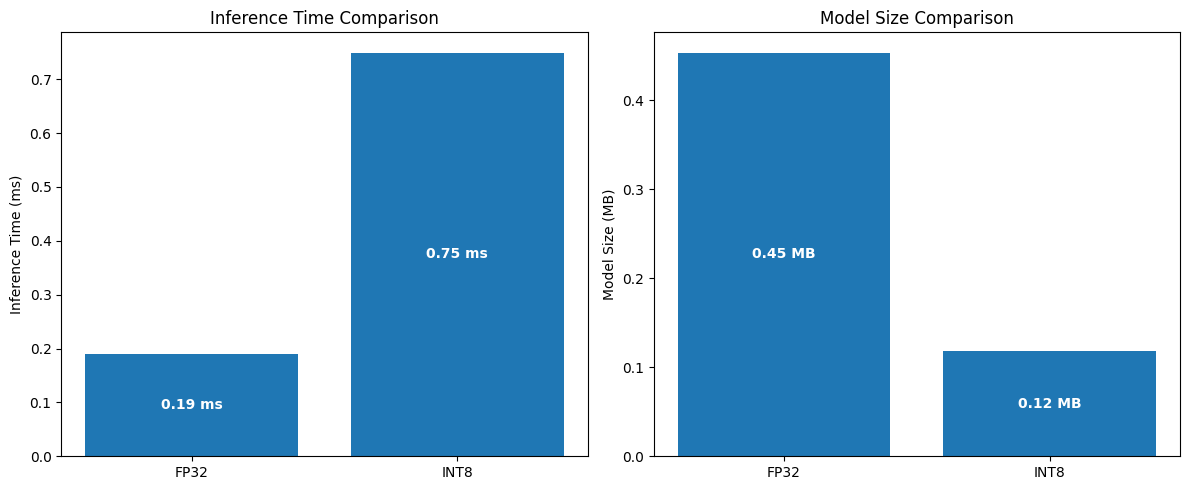

In [ ]:
## 5. Python Code Examples
### Example 1: Simple PyTorch Model with Dynamic Quantization

import os
# Set the quantized engine
# torch.backends.quantized.engine = "fbgemm"
torch.backends.quantized.engine = "qnnpack" # if you're using macos

# Define a simple neural network model
class SimpleModel(nn.Module):
    def __init__(self, input_size=784, hidden_size=128, output_size=10):
        super(SimpleModel, self).__init__()
        # A simple feed-forward network with two hidden layers
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        return self.output(x)

# Create model instances
fp32_model = SimpleModel().to(device)
fp32_model.eval()  # Set to evaluation mode

# Generate sample input data (simulating MNIST digit)
batch_size = 32
input_data = torch.randn(batch_size, 784, device=device)

# Benchmark the FP32 model
def benchmark_model(model, input_data, num_runs=100):
    # Warmup
    for _ in range(10):
        _ = model(input_data)
    
    # Time execution
    torch.cuda.synchronize() if device.type == 'cuda' else None
    start_time = time.time()
    
    for _ in range(num_runs):
        _ = model(input_data)
    
    torch.cuda.synchronize() if device.type == 'cuda' else None
    end_time = time.time()
    
    return (end_time - start_time) / num_runs

# Ensure input data is on correct device
input_data = input_data.to(device)

# Benchmark FP32 model
fp32_time = benchmark_model(fp32_model, input_data)
print(f"FP32 inference time: {fp32_time*1000:.3f} ms")

# Quantize the model (note: dynamic quantization only works on CPU)
# Move model to CPU for quantization
fp32_model_cpu = SimpleModel().to('cpu')
fp32_model_cpu.load_state_dict(fp32_model.to('cpu').state_dict())
fp32_model_cpu.eval()

# Configure quantization (8-bit weights, FP32 activations)
quantized_model = quantize_dynamic(
    fp32_model_cpu,                 # The model to quantize
    {nn.Linear},                    # Specify which layers to quantize
    dtype=torch.qint8                # Target quantization data type
)

# Benchmark quantized model (on CPU)
input_data_cpu = input_data.to('cpu')
int8_time = benchmark_model(quantized_model, input_data_cpu)
print(f"INT8 inference time: {int8_time*1000:.3f} ms")
print(f"Speedup: {fp32_time/int8_time:.2f}x")

# Compare model sizes
def get_model_size(model):
    # Get model size in MB
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size_in_mb = (param_size + buffer_size) / 1024**2
    return size_in_mb

fp32_size = get_model_size(fp32_model_cpu)
int8_size = get_model_size(quantized_model)

# print(f"FP32 model size: {fp32_size:.2f} MB")
# print(f"INT8 model size: {int8_size:.2f} MB")
# print(f"Size reduction: {fp32_size/int8_size:.2f}x")

# Save the quantized model
torch.save(quantized_model.state_dict(), "quantized_model.pth")
int8_size = os.path.getsize("quantized_model.pth") / 1024**2  # Convert bytes to MB

# Save the FP32 model
torch.save(fp32_model_cpu.state_dict(), "fp32_model.pth")
fp32_size = os.path.getsize("fp32_model.pth") / 1024**2  # Convert bytes to MB

print(f"FP32 model size: {fp32_size:.2f} MB")
print(f"INT8 model size: {int8_size:.2f} MB")
print(f"Size reduction: {fp32_size/int8_size:.2f}x")


# Visualize results
def plot_comparison(fp32_time, int8_time, fp32_size, int8_size):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Inference time comparison
    ax1.bar(['FP32', 'INT8'], [fp32_time*1000, int8_time*1000])
    ax1.set_ylabel('Inference Time (ms)')
    ax1.set_title('Inference Time Comparison')
    ax1.text(0, fp32_time*1000/2, f"{fp32_time*1000:.2f} ms", 
             ha='center', va='center', color='white', fontweight='bold')
    ax1.text(1, int8_time*1000/2, f"{int8_time*1000:.2f} ms", 
             ha='center', va='center', color='white', fontweight='bold')
    
    # Model size comparison
    ax2.bar(['FP32', 'INT8'], [fp32_size, int8_size])
    ax2.set_ylabel('Model Size (MB)')
    ax2.set_title('Model Size Comparison')
    ax2.text(0, fp32_size/2, f"{fp32_size:.2f} MB", 
             ha='center', va='center', color='white', fontweight='bold')
    ax2.text(1, int8_size/2, f"{int8_size:.2f} MB", 
             ha='center', va='center', color='white', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

plot_comparison(fp32_time, int8_time, fp32_size, int8_size)


#### NOTE:
The FP32 model appears more than twice as fast as the INT8 model because the benefits of dynamic quantization (reduced memory footprint and lower-precision arithmetic) are less pronounced in small, simple models. The overhead from quantizing operations and conversion between data types, along with highly optimized FP32 operations on modern CPUs, can result in FP32 outperforming INT8 in this scenario. This outcome is expected for lightweight models; quantization tends to shine more with larger networks or when memory bandwidth is a major factor.

## 6. Why is Quantization Useful?

### Memory Reduction
As shown above, quantization can reduce model size by ~70-75% when converting from FP32 to INT8. For a 175B parameter LLM, this could reduce memory requirements from 700GB to 175GB.

### Faster Inference
Quantised models can achieve 2-4x faster inference on hardware with INT8 acceleration. This is critical for serving LLMs at scale.

### Lower Energy Consumption
Integer operations consume significantly less energy than floating-point operations, making quantization key for sustainable AI deployment.

### Deployment on Edge Devices
Quantization enables running smaller versions of language models on devices with limited resources, expanding the reach of AI systems.

## 7. Impact of Not Using Quantization

Without quantization:

- **Scalability challenges**: Running full-precision LLMs requires massive computational resources, limiting who can deploy them
- **Reduced accessibility**: Higher costs for inference make AI services more expensive for end users
- **Limited deployment options**: Many edge devices simply cannot run full-precision models
- **Environmental impact**: Higher energy consumption from using full-precision operations

Real-world applications that rely on quantization:
- On-device language translation
- Voice assistants with local processing
- Text generation APIs that need to serve many users simultaneously

## 8. Conclusion & Further Reading

Quantization is a critical technique for making LLMs more efficient and accessible. It enables:
- Reduced memory requirements (up to 75% reduction)
- Faster inference (2-4x improvement)
- Lower energy consumption
- Wider deployment options

Recent trends in LLM quantization include pushing to even lower precision (4-bit or even 2-bit) with acceptable quality trade-offs and developing specialized techniques for transformer architectures.

### Further Reading
- [PyTorch Quantization Documentation](https://pytorch.org/docs/stable/quantization.html)
- [GPTQ: Accurate Post-Training Quantization for GPT Models](https://arxiv.org/abs/2210.17323)
- [ZeroQuant: Efficient and Affordable Post-Training Quantization for LLMs](https://arxiv.org/abs/2206.01861)
- [Faster Transformer Inference with NVIDIA TensorRT](https://developer.nvidia.com/blog/optimizing-t5-and-gpt-2-for-real-time-inference-with-tensorrt/)